# Rotating shaft mounted with roller bearing
This example shows the simulation of the thermal behaviour of a rotating shaft mounted with a roller bearing.
The speed and temperature dependent heat loss of the bearing as well as the speed and temperature dependent convection on the outer surfaces of the construction parts is modeled.  

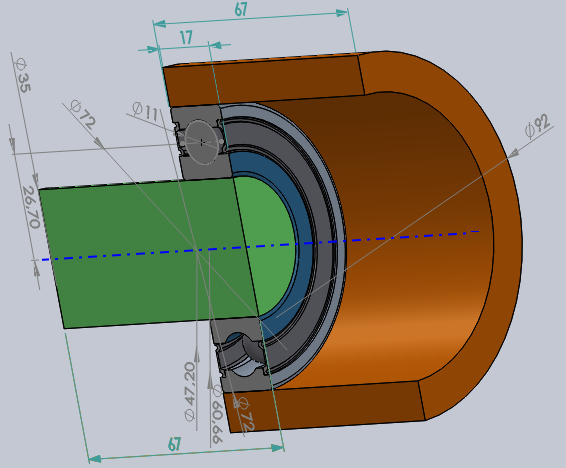

## Model creation
This is the model of a single row angular contact ball bearing. It is of the type Schaeffler S6207-2RSR. The bearing is sealed and lubricated with grease:

- Model input is the changing rotational speed over time
- Heat loss is modeled as a time-variable function of speed and temperature
- Heat loss occures on the rolling contact and the seal contact
- Bearing conductance is a function of speed
- Heat transfer to environment is a function of tempertaure and rotational speed

In [1]:
from math import tau

import pyvista as pv
pv.set_jupyter_backend('static')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from thermca import *

with Asm() as casing_asm:
    bear_casing = Cyl(        
        inner_rad=.036,
        outer_rad=.046,
        lgth=.017,
    )
    free_casing = Cyl(
        posn=(.017, 0., 0.),
        inner_rad=.036,
        outer_rad=.046,
        lgth=.05,
    )
    outer_race = Cyl(        
        inner_rad=.031,
        outer_rad=.036,
        lgth=.017,
    )
    Surf(
        name='free',
        faces=[
            bear_casing.face.base, bear_casing.face.outer,
            free_casing.face.outer, free_casing.face.end, free_casing.face.inner,
            outer_race.face.base, outer_race.face.end,
        ]
    )
    Surf(
        name='raceway',
        faces=[outer_race.face.inner],
    )
    
with Asm() as shaft_asm:
    free_shaft = Cyl(                
        posn=(-.05, 0., 0.),
        outer_rad=.0175,
        lgth=.05,      
    )
    bear_shaft = Cyl(
        outer_rad=.0175,
        lgth=.017,
    )
    inner_race = Cyl(        
        inner_rad=.0175,
        outer_rad=.0228,
        lgth=.017,        
    )
    Surf(
        name='free',
        faces=[
            free_shaft.face.base, free_shaft.face.outer,
            bear_shaft.face.end,
        ]
    )
    Surf(
        name='bear_left',
        faces=[inner_race.face.base,]
    )
    Surf(
        name='raceway',
        faces=[inner_race.face.outer,]
    )
    Surf(
        name='bear_right',
        faces=[inner_race.face.end,]
    )


with Model() as model:
    # Changing speed over time as model input 
    rpm = tau/60
    speed_table = np.array(
        [[0, 2500, 4500], 
        [1000*rpm, 4000*rpm, 0*rpm]]
    ).T
    measured_rot_freq = Input(
        speed_table
    )
    
    # Parts
    casing = LPPart(
        asm=casing_asm,
        matl=solids.steel,
        init_temp = 20.,
        name='casing',
    )
    shaft = LPPart(
        asm=shaft_asm,
        matl=solids.steel,
        init_temp = 20.,
        name='shaft',
    )
    internals = Node(                
        posn=(.017/2, .02675, 0.),
        capy=34+54.4,
        init_temp = 20.,
        name='internals',
    )
    
    # Conduction of rolling contact
    bearing_cond_func = bearing.cond(            
        inner_rad=.035/2., 
        rlr_rad=.011/2., 
        rlr_count=9, 
        rot_freq=measured_rot_freq.value,
        factor=2.,  # Over half of bearing
    )
    CondLink.multi(        
        internals,
        [casing.surf.raceway, shaft.surf.raceway],
        bearing_cond_func,
    )    
    
    # Bearing heat loss
    mean_rad = (.0175+.036)/2.
    load = 1000.
    lube = fluids.oil_vg100 
    inner_share = bearing.inner_race_heat_loss_share(
        mean_rad=mean_rad,
        rlr_rad=.011/2.,
        cont_ang=.628
    )
    outer_share = (1-inner_share)
    # Loss on inner race
    HeatSource(
        shaft.surf.raceway,
        bearing.heat_loss(
            bear_type='grooved ball',
            mean_rad=mean_rad,
            rot_freq=measured_rot_freq.value,
            load=load,
            lube=lube,
            lube_type='grease',
            factor=inner_share/2)
    )
    # Loss on balls
    HeatSource(
        internals,
        bearing.heat_loss(
            bear_type='grooved ball',
            mean_rad=mean_rad,
            rot_freq=measured_rot_freq.value,
            load=load,
            lube=lube,
            lube_type='grease',
            factor=inner_share/2. + outer_share/2.
        )
    )
    # Loss on outer race
    HeatSource(
        casing.surf.raceway,
        bearing.heat_loss(
            bear_type='grooved ball',
            mean_rad=mean_rad,
            rot_freq=measured_rot_freq.value,
            load=load,
            lube=lube,
            lube_type='grease',
            factor=outer_share/2)
    )
    # Seal heat loss
    HeatSource.multi(
        [shaft.surf.bear_left, shaft.surf.bear_right],
        bearing.seal_heat_loss(
            bear_type='angular contact ball',
            seal_rad=.023,
            outer_rad=.036,
            rot_freq=measured_rot_freq.value,
            factor=.5,)  # half on each side
    )
    
    # Thermal coupling to environment
    air = BoundNode(
        posn=(0., .06, 0.),
        temp=20.,
        name='air'
    )
    casing_to_env = FilmLink(
        casing.surf.free,
        air,
        combd_film.conv_radn_room(),
    )
    # Free and forced convection shaft
    film_shaft = combd_film.mix_conv(
        forced_conv.rot_cyl_in_air(
            rot_freq=measured_rot_freq.value,
            rad=free_shaft.outer_rad,
        ),
        free_conv.horiz_cyl(
            rad=free_shaft.outer_rad
        )
    )        
    shaft_to_env = FilmLink(
        shaft.surf.free,
        air,
        film_shaft,
    )

## Simulation
### Create a runnable network

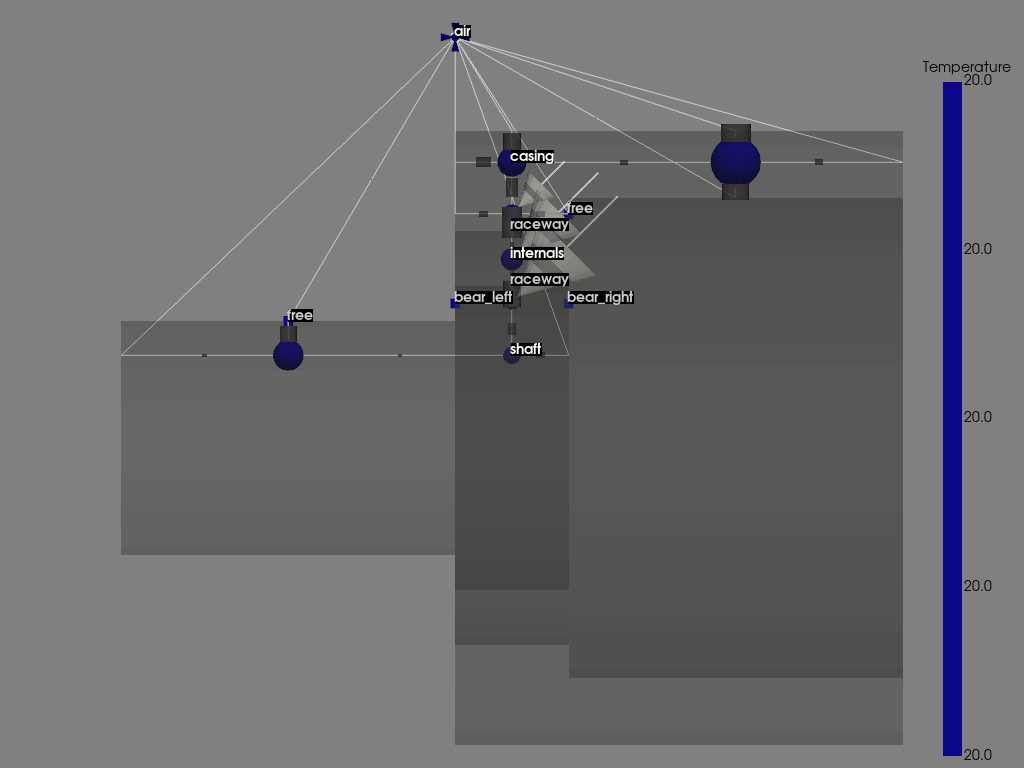

In [2]:
net = Network(model)

def show_thight(plot):
    plot.camera.zoom(1.6)
    plot.show()
    
show_thight(net.plot(draw_2d=True))

### Simulate warming over time

In [3]:
sim_time = 120.*60
result = net.sim([0., sim_time])

Simulation run progress, speed as sim. time vs. real time:
 0% 100% done.


## Result analysis
### Thermal beheaviour during cooling

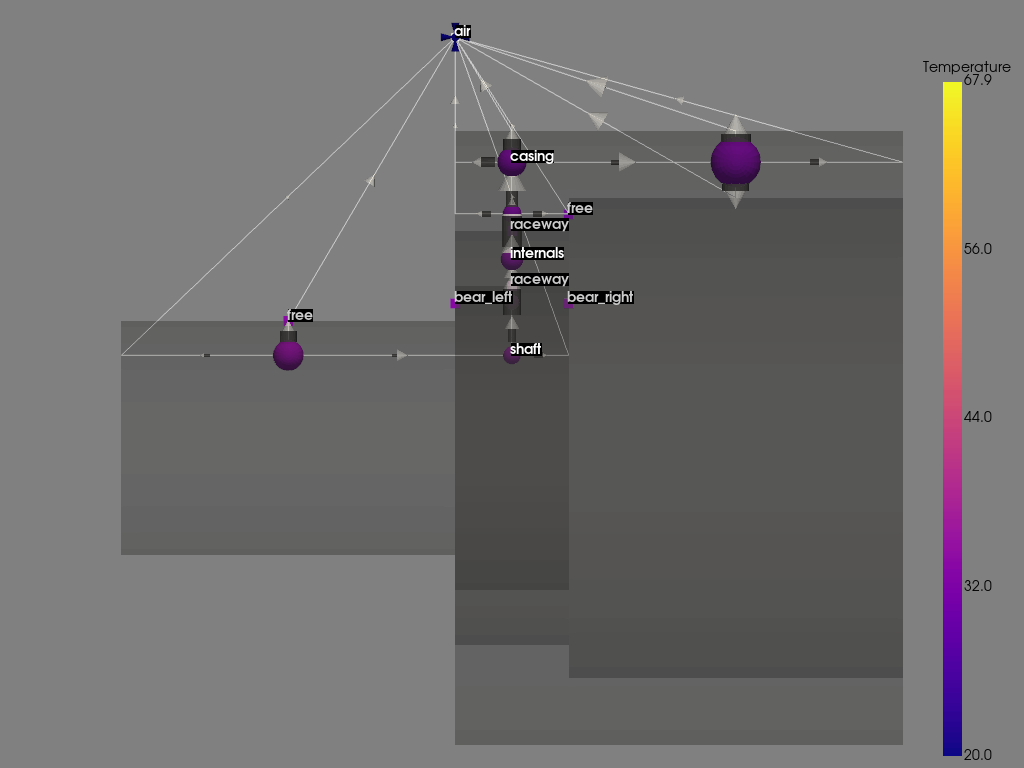

In [4]:
show_thight(result.plot(draw_2d=True))

### Temperature over time

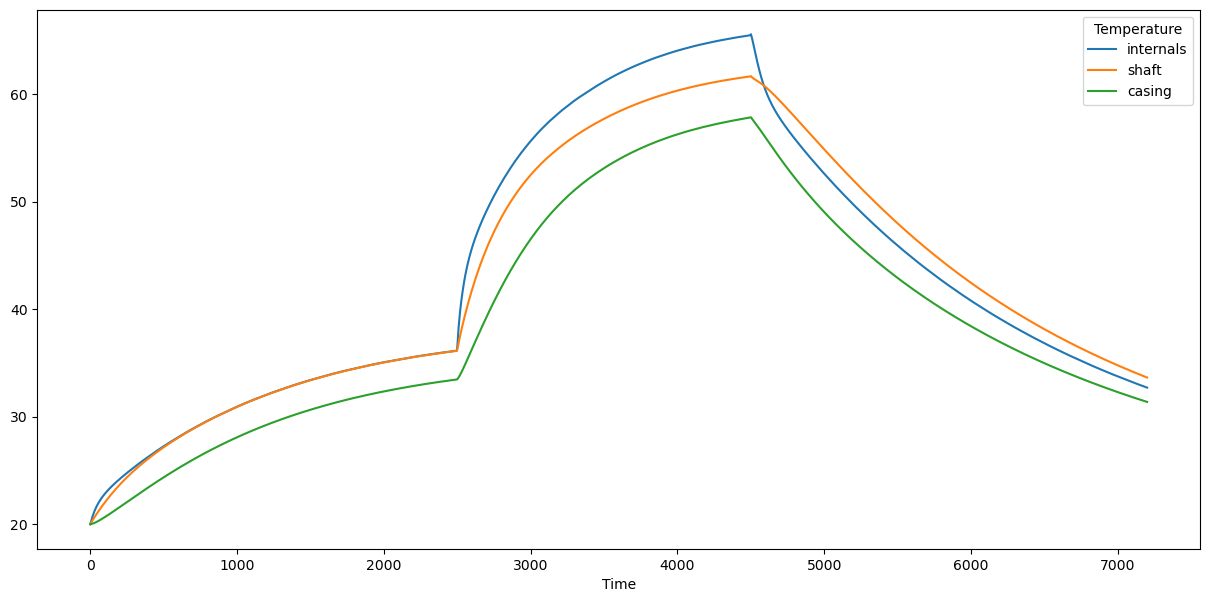

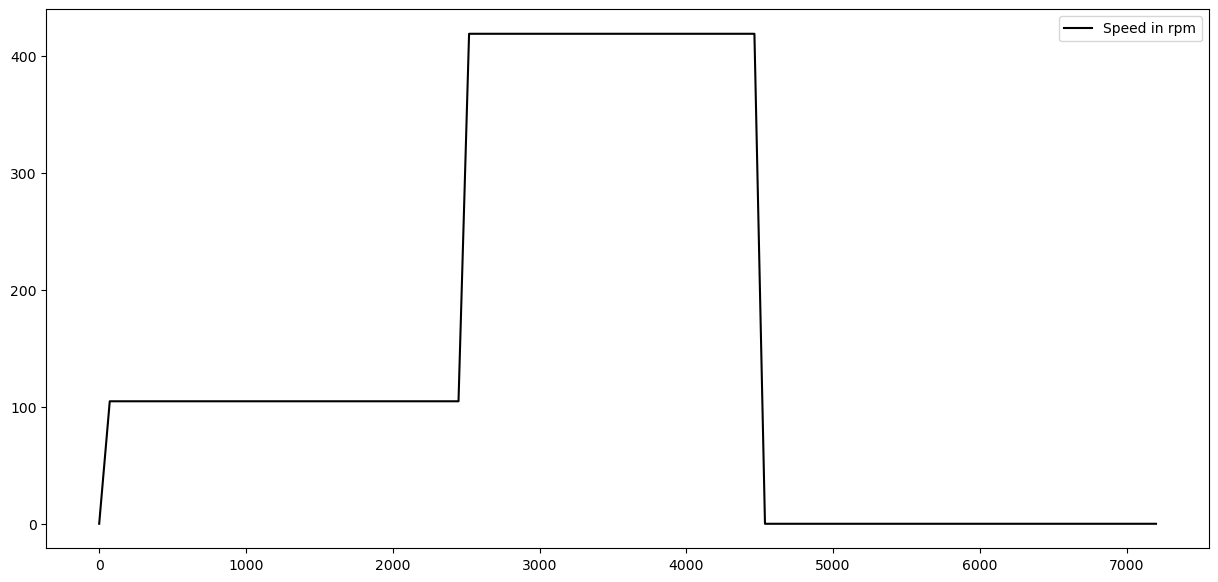

In [5]:
figsize=(15, 7)  # adjust desired figure size here
temp_df = pd.concat([
    result[internals].temp_frame(),
    result[shaft].temp_frame(),
    result[casing].temp_frame(),
], axis=1)
temp_df.plot(figsize=figsize)
speed_table = np.array([[0, 2500, 4500], 
                        [1000*rpm, 4000*rpm, 0*rpm]])
fig, ax = plt.subplots(figsize=figsize)
times = np.linspace(0, sim_time, 101)
plt.plot(times, speed_table[1, np.searchsorted(speed_table[0], times) - 1], 'k', label=('Speed in rpm'));
plt.legend();

### Heat loss over time
The heat loss is dependent of speed and temperature (lube viscosity). Therfore it changes signiffcantly over time.

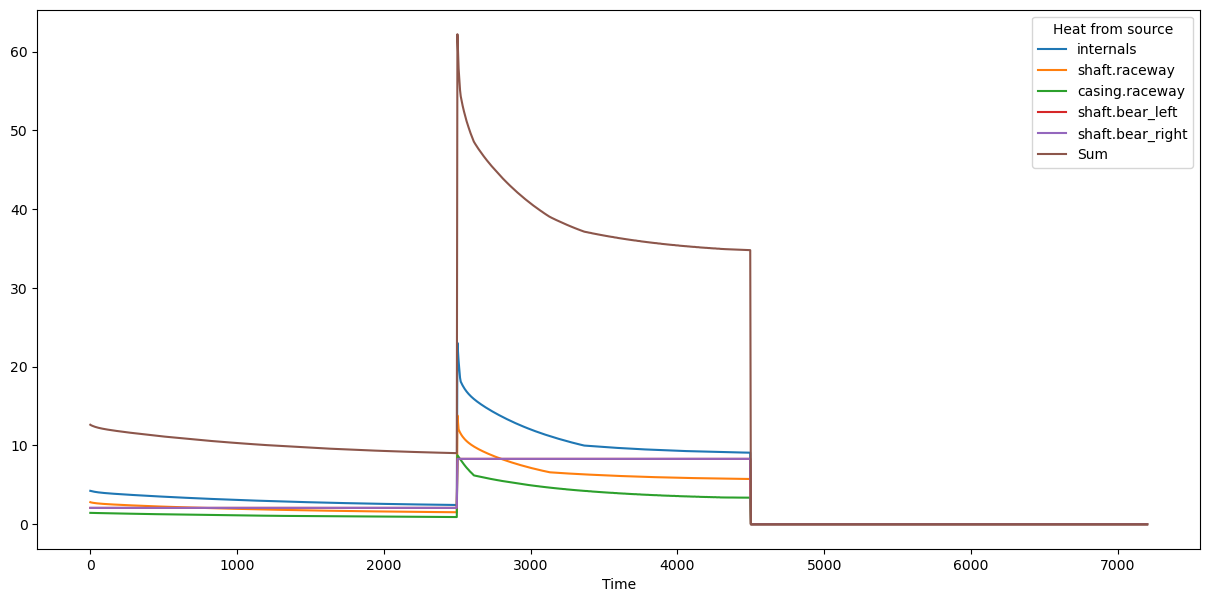

In [6]:
heat_src_df = pd.concat([
    result[internals].heat_src_frame(),
    result[shaft.surf.raceway].heat_src_frame(),
    result[casing.surf.raceway].heat_src_frame(),
    result[shaft.surf.bear_left].heat_src_frame(),
    result[shaft.surf.bear_right].heat_src_frame(),
], axis=1)
heat_src_df['Sum'] = (
    heat_src_df['internals'] 
    + heat_src_df['shaft.raceway'] 
    + heat_src_df['casing.raceway']
    + heat_src_df['shaft.bear_left'] 
    + heat_src_df['shaft.bear_right']
)
heat_src_df.plot(secondary_y='sum', figsize=figsize);

### Film coefficient over time
Film coefficient for the heat excange of shaft and casing with air

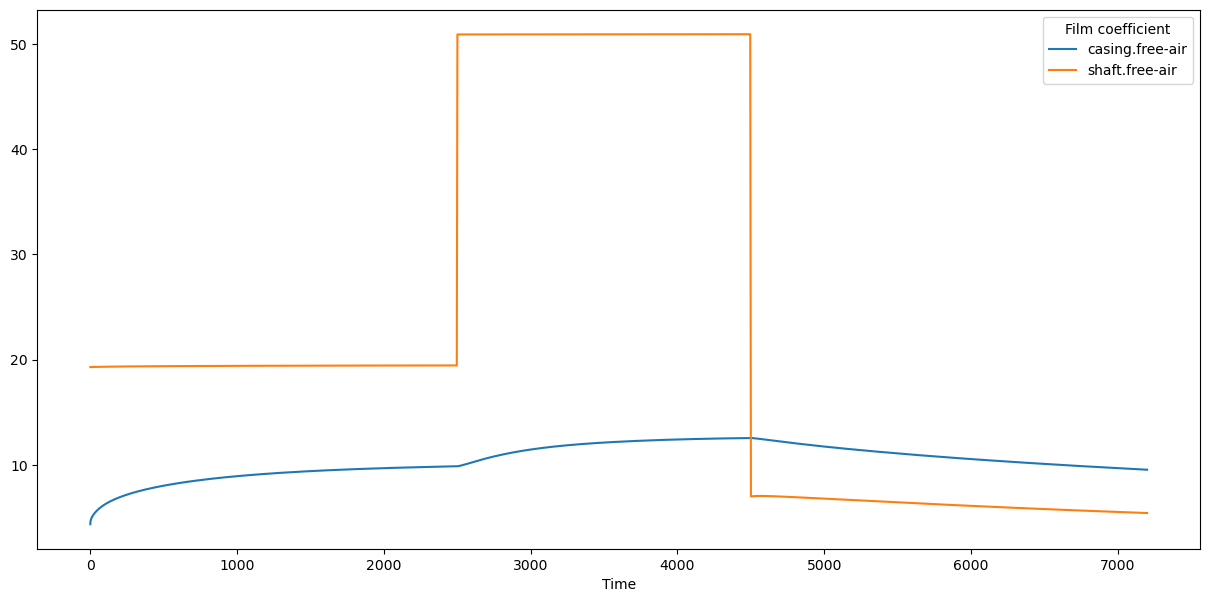

In [7]:
pd.concat([
    result[casing_to_env].film_frame(),
    result[shaft_to_env].film_frame(),
], axis=1).plot(figsize=figsize);